In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score


# 1. Definición del problema

Se desarrolló un modelo de clasificación para predecir la ocurrencia de una alarma crítica en las próximas 3 horas.

- Frecuencia de registros: cada 5 minutos.
- Horizonte de predicción: 36 registros (o sea 3 horas).
- Variable objetivo (`target`): toma valor 1 si ocurre al menos una alarma crítica dentro del horizonte futuro definido.

In [2]:
df = pd.read_csv('data.csv', parse_dates=["ts"])

# Ordenar temporalmente
df = df.sort_values("ts")

# Establecer índice temporal
df.set_index("ts", inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 345600 entries, 2025-10-14 15:05:29.502750+00:00 to 2026-02-11 15:04:29.502750+00:00
Data columns (total 38 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   board_mqtt_id         345600 non-null  object 
 1   equipment_id          345600 non-null  int64  
 2   pos_id                345600 non-null  int64  
 3   client_id             345600 non-null  int64  
 4   category_name         345600 non-null  object 
 5   programmer_model      345600 non-null  object 
 6   compressor_model      345600 non-null  object 
 7   refrigerant_code      345600 non-null  object 
 8   municipality_name     345600 non-null  object 
 9   department_name       345600 non-null  object 
 10  probe_1               345600 non-null  float64
 11  probe_2               345600 non-null  float64
 12  probe_3               345600 non-null  float64
 13  probe_4               345600 non-null  int64

In [3]:
df.head()

,board_mqtt_id,equipment_id,pos_id,client_id,category_name,programmer_model,compressor_model,refrigerant_code,municipality_name,department_name,...,alarm_bit9,alarm_bit10,alarm_bit11,alarm_bit12,alarm_bit13,alarms_bitfield,has_any_alarm,is_alarm_critical,is_alarm_temperature,is_alarm_warning
ts,,,,,,,,,,,,,,,,,,,,,
2025-10-14 15:05:29.502750+00:00,K48R01,12,1,5,Congelación,EV3224N9RRXRS1,DANFOSS-SC15CL,R-290,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",...,0,0,0,0,0,0,False,False,False,False
2025-10-14 15:05:29.502750+00:00,KDE01,1,1,1,Refrigeración,TC900E_V4,EMBRACO-EMI60HER,R-134A,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",...,0,0,1,0,0,2056,True,True,False,False
2025-10-14 15:06:29.502750+00:00,K48R01,12,1,5,Congelación,EV3224N9RRXRS1,DANFOSS-SC15CL,R-290,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",...,0,0,0,0,0,0,False,False,False,False
2025-10-14 15:06:29.502750+00:00,KDE01,1,1,1,Refrigeración,TC900E_V4,EMBRACO-EMI60HER,R-134A,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",...,0,0,1,0,0,2056,True,True,False,False
2025-10-14 15:07:29.502750+00:00,K48R01,12,1,5,Congelación,EV3224N9RRXRS1,DANFOSS-SC15CL,R-290,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",...,0,0,0,0,0,0,False,False,False,False


In [4]:
df_eq = df[df["equipment_id"] == 12].copy()
df_eq = df_eq.sort_index()

df_eq = df_eq.rename(columns={
    "probe_1": "temp_cabina",
    "probe_2": "temp_evaporador",
    "probe_3": "temp_condensador",
    "status_defrost": "deshielo",
    "status_door": "puerta_abierta",
    "setpoint": "setpoint_objetivo",
    "economic_setpoint": "setpoint_economico"
})

df_eq["error_cabina"] = df_eq["temp_cabina"] - df_eq["setpoint_objetivo"]

In [5]:
df_eq.columns


Index(['board_mqtt_id', 'equipment_id', 'pos_id', 'client_id', 'category_name',
       'programmer_model', 'compressor_model', 'refrigerant_code',
       'municipality_name', 'department_name', 'temp_cabina',
       'temp_evaporador', 'temp_condensador', 'probe_4', 'probe_5',
       'puerta_abierta', 'deshielo', 'setpoint_objetivo', 'setpoint_economico',
       'alarm_bit0', 'alarm_bit1', 'alarm_bit2', 'alarm_bit3', 'alarm_bit4',
       'alarm_bit5', 'alarm_bit6', 'alarm_bit7', 'alarm_bit8', 'alarm_bit9',
       'alarm_bit10', 'alarm_bit11', 'alarm_bit12', 'alarm_bit13',
       'alarms_bitfield', 'has_any_alarm', 'is_alarm_critical',
       'is_alarm_temperature', 'is_alarm_warning', 'error_cabina'],
      dtype='object')

# 2. Ingeniería de características

Se construyeron variables en cuatro categorías principales:

### 2.1 Estado actual
- `temp_cabina`
- `temp_evaporador`
- `temp_condensador`
- `error_cabina`
- `puerta_abierta`
- `deshielo`

### 2.2 Dinámica
- Diferencias temporales mediante `diff()`:
  - `cabina_diff`
  - `evaporador_diff`
  - `error_diff`

### 2.3 Memoria (lags)
- Valores pasados a 6, 12 y 24 intervalos:
  - `cabina_lag_6`, `cabina_lag_12`, `cabina_lag_24`
  - `error_lag_6`, `error_lag_12`, `error_lag_24`

### 2.4 Variabilidad
- Desviación estándar móvil en ventanas de 12 y 24 registros:
  - `cabina_std_12`, `cabina_std_24`
  - `error_std_12`, `error_std_24`

El conjunto final estuvo compuesto por 19 variables predictoras.

In [6]:
HORIZON = 36

df_eq["target"] = (
    df_eq["is_alarm_critical"]
    .rolling(window=HORIZON, min_periods=1)
    .max()
    .shift(-HORIZON)
)


In [7]:
df_eq["cabina_diff"] = df_eq["temp_cabina"].diff()
df_eq["evaporador_diff"] = df_eq["temp_evaporador"].diff()
df_eq["error_diff"] = df_eq["error_cabina"].diff()


In [8]:
for lag in [6, 12, 24]:
    df_eq[f"cabina_lag_{lag}"] = df_eq["temp_cabina"].shift(lag)
    df_eq[f"error_lag_{lag}"] = df_eq["error_cabina"].shift(lag)


In [9]:
for w in [12, 24]:
    df_eq[f"cabina_std_{w}"] = df_eq["temp_cabina"].rolling(w).std()
    df_eq[f"error_std_{w}"] = df_eq["error_cabina"].rolling(w).std()


In [10]:
df_eq.columns.tolist()


['board_mqtt_id',
 'equipment_id',
 'pos_id',
 'client_id',
 'category_name',
 'programmer_model',
 'compressor_model',
 'refrigerant_code',
 'municipality_name',
 'department_name',
 'temp_cabina',
 'temp_evaporador',
 'temp_condensador',
 'probe_4',
 'probe_5',
 'puerta_abierta',
 'deshielo',
 'setpoint_objetivo',
 'setpoint_economico',
 'alarm_bit0',
 'alarm_bit1',
 'alarm_bit2',
 'alarm_bit3',
 'alarm_bit4',
 'alarm_bit5',
 'alarm_bit6',
 'alarm_bit7',
 'alarm_bit8',
 'alarm_bit9',
 'alarm_bit10',
 'alarm_bit11',
 'alarm_bit12',
 'alarm_bit13',
 'alarms_bitfield',
 'has_any_alarm',
 'is_alarm_critical',
 'is_alarm_temperature',
 'is_alarm_warning',
 'error_cabina',
 'target',
 'cabina_diff',
 'evaporador_diff',
 'error_diff',
 'cabina_lag_6',
 'error_lag_6',
 'cabina_lag_12',
 'error_lag_12',
 'cabina_lag_24',
 'error_lag_24',
 'cabina_std_12',
 'error_std_12',
 'cabina_std_24',
 'error_std_24']

In [11]:
model_features = [
    "temp_cabina",
    "temp_evaporador",
    "temp_condensador",
    "error_cabina",
    "puerta_abierta",
    "deshielo",
    "cabina_diff",
    "evaporador_diff",
    "error_diff",
    "cabina_lag_6",
    "cabina_lag_12",
    "cabina_lag_24",
    "error_lag_6",
    "error_lag_12",
    "error_lag_24",
    "cabina_std_12",
    "cabina_std_24",
    "error_std_12",
    "error_std_24"
]


In [12]:
df_model = df_eq[model_features + ["target"]].dropna().copy()
df_model["target"] = df_model["target"].astype(int)


In [13]:
df_model.shape
df_model["target"].value_counts(normalize=True)


target
0    0.645322
1    0.354678
Name: proportion, dtype: float64

In [14]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 172740 entries, 2025-10-14 15:29:29.502750+00:00 to 2026-02-11 14:28:29.502750+00:00
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp_cabina       172740 non-null  float64
 1   temp_evaporador   172740 non-null  float64
 2   temp_condensador  172740 non-null  float64
 3   error_cabina      172740 non-null  float64
 4   puerta_abierta    172740 non-null  int64  
 5   deshielo          172740 non-null  int64  
 6   cabina_diff       172740 non-null  float64
 7   evaporador_diff   172740 non-null  float64
 8   error_diff        172740 non-null  float64
 9   cabina_lag_6      172740 non-null  float64
 10  cabina_lag_12     172740 non-null  float64
 11  cabina_lag_24     172740 non-null  float64
 12  error_lag_6       172740 non-null  float64
 13  error_lag_12      172740 non-null  float64
 14  error_lag_24      172740 non-null  float64
 15  cabina_s

# 3. División temporal de los datos

Se realizó una división respetando el orden cronológico:

- 80% entrenamiento
- 20% prueba

Tamaños:

- Entrenamiento: 138,192 registros
- Prueba: 34,548 registros

Distribución de clases:

- Clase 0: 64.5%
- Clase 1: 35.5%


In [15]:
split_index = int(len(df_model) * 0.8)

train = df_model.iloc[:split_index]
test  = df_model.iloc[split_index:]

X_train = train.drop("target", axis=1)
y_train = train["target"]

X_test = test.drop("target", axis=1)
y_test = test["target"]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (138192, 19)
Test shape: (34548, 19)


# 4. Modelos evaluados





## 4.1 Regresión Logística

- Accuracy: 0.77
- ROC AUC: 0.75
- Recall clase 1: 0.69

In [16]:


scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [17]:

log_model = LogisticRegression(
    class_weight="balanced",
    max_iter=1000
)

log_model.fit(X_train_scaled, y_train)


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [18]:
y_pred = log_model.predict(X_test_scaled)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]


In [19]:

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.84      0.80      0.82     23192
           1       0.63      0.69      0.66     11356

    accuracy                           0.77     34548
   macro avg       0.74      0.75      0.74     34548
weighted avg       0.77      0.77      0.77     34548

ROC AUC: 0.7521942442803454


In [20]:

cm = confusion_matrix(y_test, y_pred)
print(cm)


[[18585  4607]
 [ 3504  7852]]


## 4.2 Random Forest

- Accuracy: 0.89
- ROC AUC: 0.90
- Recall clase 1: 0.77


In [21]:

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.89      0.96      0.92     23192
           1       0.90      0.77      0.83     11356

    accuracy                           0.89     34548
   macro avg       0.90      0.86      0.88     34548
weighted avg       0.89      0.89      0.89     34548

ROC AUC: 0.9019079558959309


## 4.3 XGBoost (modelo seleccionado)

- Accuracy: 0.90
- ROC AUC: 0.9089
- Precision clase 1: 0.92
- Recall clase 1: 0.78
- F1-score clase 1: 0.84


In [22]:

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,  # podemos ajustar luego
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)



,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [23]:
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]


In [24]:

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_prob_xgb))


              precision    recall  f1-score   support

           0       0.90      0.97      0.93     23192
           1       0.92      0.78      0.84     11356

    accuracy                           0.90     34548
   macro avg       0.91      0.87      0.89     34548
weighted avg       0.91      0.90      0.90     34548

ROC AUC: 0.9089347682898513


In [25]:
for t in [0.5, 0.6, 0.65, 0.7]:
    y_pred_custom = (y_prob_xgb >= t).astype(int)
    print(f"\nThreshold = {t}")
    print(classification_report(y_test, y_pred_custom))



Threshold = 0.5
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     23192
           1       0.92      0.78      0.84     11356

    accuracy                           0.90     34548
   macro avg       0.91      0.87      0.89     34548
weighted avg       0.91      0.90      0.90     34548


Threshold = 0.6
              precision    recall  f1-score   support

           0       0.90      0.97      0.93     23192
           1       0.93      0.77      0.84     11356

    accuracy                           0.91     34548
   macro avg       0.91      0.87      0.89     34548
weighted avg       0.91      0.91      0.90     34548


Threshold = 0.65
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     23192
           1       0.94      0.77      0.84     11356

    accuracy                           0.91     34548
   macro avg       0.92      0.87      0.89     34548
weighted avg       0.9

In [26]:
FINAL_THRESHOLD = 0.65

y_pred_final = (y_prob_xgb >= FINAL_THRESHOLD).astype(int)


### Variables más relevantes

Las variables con mayor importancia en XGBoost fueron:

1. `temp_evaporador`
2. `error_cabina`
3. `temp_cabina`
4. `cabina_diff`
5. `evaporador_diff`
6. `error_lag_24`
7. `puerta_abierta`
8. `error_std_12`


In [27]:
# Obtener importancias
importances = xgb_model.feature_importances_

feature_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

feature_importance.head(10)


,feature,importance
1,temp_evaporador,0.138202
3,error_cabina,0.134896
0,temp_cabina,0.096477
6,cabina_diff,0.078195
7,evaporador_diff,0.056763
14,error_lag_24,0.056476
4,puerta_abierta,0.055148
17,error_std_12,0.050612
2,temp_condensador,0.049112
18,error_std_24,0.048989


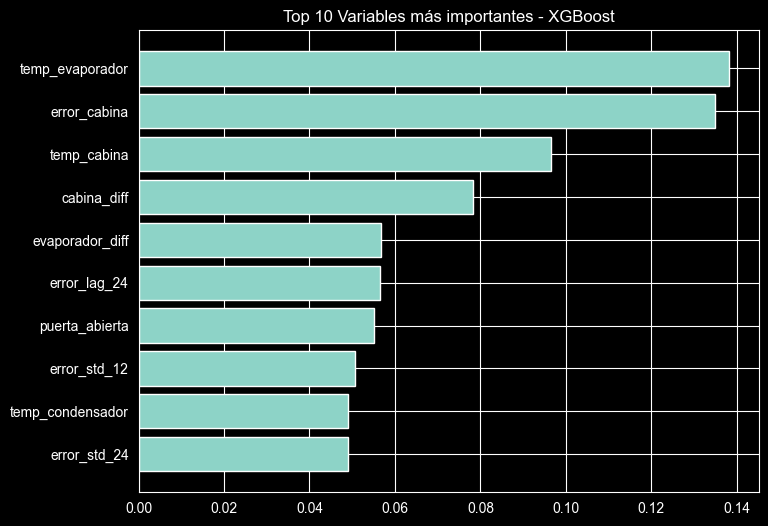

In [28]:
plt.figure(figsize=(8,6))
plt.barh(feature_importance["feature"][:10],
         feature_importance["importance"][:10])
plt.gca().invert_yaxis()
plt.title("Top 10 Variables más importantes - XGBoost")
plt.show()


## 5. Validación cruzada temporal

Se aplicó `TimeSeriesSplit` con 5 particiones.

ROC por ventana:

- 0.8927
- 0.9012
- 0.9211
- 0.9235
- 0.9036

ROC promedio:

- 0.9084

Estos resultados indican estabilidad del modelo y adecuada generalización temporal.

In [29]:
tscv = TimeSeriesSplit(n_splits=5)

roc_scores = []

for train_index, test_index in tscv.split(df_model):

    train = df_model.iloc[train_index]
    test  = df_model.iloc[test_index]

    X_train = train.drop("target", axis=1)
    y_train = train["target"]

    X_test = test.drop("target", axis=1)
    y_test = test["target"]

    model = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric="logloss",
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, y_prob)
    roc_scores.append(roc)

print("ROC por ventana:", roc_scores)
print("ROC promedio:", np.mean(roc_scores))


ROC por ventana: [0.8927931686410289, 0.901215839068694, 0.9211609028110433, 0.9235177650486819, 0.9036731882749794]
ROC promedio: 0.9084721727688855
